In [1]:
from IPython.html.services.config import ConfigManager
from IPython.paths import locate_profile
cm = ConfigManager(profile_dir=locate_profile(get_ipython().profile))

cm.update('notebook', {"load_extensions": {"livereveal/main": True}})
cm.update('livereveal', {
    'theme': 'simple',
    'transition': 'linear',
    'slideNumber': True,
    'start_slideshow_at': 'selected',
    'scroll': True,
})

/Users/gorosz/anaconda3/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


{'scroll': True,
 'slideNumber': True,
 'start_slideshow_at': 'selected',
 'theme': 'simple',
 'transition': 'linear'}

# Mining Hungarian texts

## Who?

* György Orosz
* NLP engineer @ LogMeIn
* [gyorgy@orosz.link](mailto:gyorgy@orosz.link) / http://github.com/oroszgy

<center><img src="./img/poll_results1.png" alt="Results" style="width: 700px;"/>
<img src="./img/poll_results2.png" alt="Results" style="width: 700px;"/></center>

## What?


<center><img src="./img/poll_results3.png" alt="Results" style="width: 800px;"/></center>

We are going to focus on freely available tools, which you can use in your daily work to extract structured info from unstructured textual data.

## Agenda

1. Practical NLP in Python: `spaCy` and `textacy`, 
2. Describing documents with words
2. Document categorization
3. Sentiment analysis
5. Named entities
6. Identifying concepts in documents

## Why?

* (Until nowadays there was a) Lack of easily usable, open-source Hungarian tools
* There is not much NLP applied outside academia
* Would love encourage everyone to use and build NLP tools
* Promote my pet projects :)

# SpaCy

Industrial-strength Natural Language Processing (NLP) with Python and Cython

<center><a href="http://spacy.io"><img src="./img/spacy.png" alt="Spacy" style="width: 800px;"/></a></center>

* support basic language processings steps
* multilingual
* deals with noisy texts
* blazingly fast as it is written in Cython
* multithreading capability (no GIL!)
* easily pluggable to ML pipelines
* living open-source community

## 101

In [2]:
from spacy.en import English

nlp = English()

doc = nlp(
    "Trump was born and raised in Queens, New York City, and earned an economics degree from the Wharton School."
    " Later, he took charge of The Trump Organization, the real estate and construction firm founded by his paternal "
    "grandmother, which he ran for 45 years until 2016. During his real estate career, Trump built, "
    "renovated, and managed numerous office towers, hotels, casinos, and golf courses. ")

In [3]:
(list(doc.sents))

[Trump was born and raised in Queens, New York City, and earned an economics degree from the Wharton School.,
 Later, he took charge of The Trump Organization, the real estate and construction firm founded by his paternal grandmother, which he ran for 45 years until 2016.,
 During his real estate career, Trump built, renovated, and managed numerous office towers, hotels, casinos, and golf courses.]

In [4]:
print("\n".join(
    ["{}\t{}\t{}\t{}\t{}\t{}".format(tok.i, tok.text, tok.lemma_, tok.tag_, tok.dep_, tok.head.i)
        for tok in list(doc.sents)[0]
]))

0	Trump	trump	NNP	nsubjpass	2
1	was	be	VBD	auxpass	2
2	born	bear	VBN	ROOT	2
3	and	and	CC	cc	2
4	raised	raise	VBN	conj	2
5	in	in	IN	prep	4
6	Queens	queens	NNP	pobj	5
7	,	,	,	punct	6
8	New	new	NNP	compound	9
9	York	york	NNP	compound	10
10	City	city	NNP	conj	6
11	,	,	,	punct	10
12	and	and	CC	cc	4
13	earned	earn	VBD	conj	4
14	an	an	DT	det	16
15	economics	economics	NN	compound	16
16	degree	degree	NN	dobj	13
17	from	from	IN	prep	16
18	the	the	DT	det	20
19	Wharton	wharton	NNP	compound	20
20	School	school	NNP	pobj	17
21	.	.	.	punct	2


In [5]:
["{}/{}".format(ent.text, ent.label_) for ent in doc.ents]

['Trump/PERSON',
 'Queens/GPE',
 'New York City/GPE',
 'the Wharton School/ORG',
 'The Trump Organization/ORG',
 '45 years until 2016/DATE',
 'Trump/PERSON']

In [6]:
from sklearn.metrics.pairwise import cosine_similarity

doc = nlp("king man woman queen")
cosine_similarity((doc[0].vector - doc[1].vector + doc[2].vector).reshape(1,-1), doc[3].vector.reshape(1,-1))[0,0]

0.78808445

In [7]:
nlp("New York").similarity(nlp("New York City"))

0.92454800882818011

## SpaCy speaks Hungarian!

It supports:
* __tokenization__
* __stop-words__
* word-vectors
* Brown clusters
* word probabilities
* Part-of-speech tagging

In [8]:
from spacy.hu import Hungarian

hu_nlp = Hungarian()
text = "A Goldman Sachs nemzetközi befektetési bank a hétfőn kezdődő brexit-tárgyalásokkal egy időben " \
       "megkezdi a költözést Londonból, jelentette be Richard Gnodde, a bank európai igazgatója a " \
       "Frankfurter Allgemeine Sonntagszeitungnak adott interjúban."
doc = hu_nlp(text)

len(doc)

33

In [9]:
word = doc[1]
word, word.is_stop, word.text, word.shape_, word.is_title

(Goldman, False, 'Goldman', 'Xxxxx', True)

If you [downloade the language model](https://github.com/oroszgy/spacy-hungarian-models) there is much more you can do:

In [10]:
import hu_tagger_web_md

hu_nlp = hu_tagger_web_md.load()
doc = hu_nlp(text)

In [11]:
hu_nlp("ablakba")[0].cluster, hu_nlp("ajtóban")[0].cluster

(227, 227)

In [12]:
hu_nlp("király").similarity(hu_nlp("császár")) > hu_nlp("király").similarity(hu_nlp("politikus"))

True

In [13]:
doc = hu_nlp("király fiú lány királynő")
cosine_similarity((doc[0].vector - doc[1].vector + doc[2].vector).reshape(1,-1), doc[3].vector.reshape(1,-1))[0,0]

0.80505663

In [28]:
["{}/{}".format(tok.text, tok.tag_) for tok in doc[9:21]]

['Zsiga/PROPN',
 'Marcellről/PROPN',
 './PUNCT',
 'Ha/SCONJ',
 'nincsenek/VERB',
 'civilek/NOUN',
 ',/PUNCT',
 'győznek/VERB',
 'a/DET',
 'segédhernyók/NOUN',
 './PUNCT',
 'Átnyomta/PROPN']

## Ok, but how can I actually _use_ it?

Could we use spaCy to extract the *meaning* of ~~life~~ a document?

Let's try to extract

* n-grams
* noun phrases (words with predefined PoS sequences)
* keywords
* keyphrases

In [15]:
import textacy

**Features**

* Language detection
* Raw text cleaning normalisation, word true-casing
* PoS tag matcher, n-gram extractor
* Keyphrase extraction, Keywords in context
* Topic models

In [16]:
text = open("./data/hvg_cikk.txt").read()
doc = hu_nlp(text)
doc[:4]

Így gondozd a civiledet

In [17]:
from textacy.text_utils import detect_language

detect_language(text)

'hu'

#### Does frequent n-grams describe the document content?

In [18]:
from textacy.extract import pos_regex_matches, ngrams
from collections import Counter

Counter([ng.text.lower() for n in [2,3] for ng in ngrams(doc, n)]).most_common(2)

[('igaz történet', 2), ('honnan van pénzük', 2)]

#### Can we get insights from the document matching PoS tags sequences?

* Spacy supports [Universal PoS tags](http://universaldependencies.org/u/pos/index.html) that is pretty easy to utilize.
* Noun phrases might a good candidates
* Got some inspiration for minining NPs from [Gabor Recski's NP chunker rules](https://github.com/recski/HunParse/blob/master/grammars/currBest.grammar)

In [19]:
Counter([np.text.lower() for np in pos_regex_matches(
    doc, "<DET>? <NUM>? <ADV>* <ADJ>* <NOUN|PROPN>+")]).most_common(3)

[('a tasz', 4), ('igaz történet', 2), ('pénzük', 2)]

#### Keyword and keyphrase extraction methods might give us better results

Textacy has various graph based keyphrase extraction methods:

* TextRank
* SingleRank
* [SGRank](http://www.aclweb.org/anthology/S15-1013)

All of them are graph based methods, using words/ngrams as nodes and their contextual cooccurrences as edge weights. Importance of nodes are calculated with PageRank.

* TextRank focuses only to words
* SingleRank extracts noun phrases (in practice n-grams)
* SGRank utilize addition stistical heuristics in addition to PageRank

In [20]:
textacy.keyterms.textrank(
    doc,
    normalize = "lower", # lemmatization is not yet availabel for Hungarian
    n_keyterms=10,
)

[('tasz', 0.015050415265867617),
 ('zsiga', 0.014922124081456092),
 ('világos', 0.011098089964988202),
 ('bíróság', 0.008442464446848923),
 ('civil', 0.00812063386302294),
 ('hernyók', 0.007797977550357589),
 ('fidesz', 0.007630629099489983),
 ('civilek', 0.007572149691218505),
 ('perben', 0.007559005770253081),
 ('független', 0.007503366408856496)]

In [21]:
textacy.keyterms.singlerank(
    doc,
    normalize = "lower", # lemmatization is not yet availabel for Hungarian
    n_keyterms=10,
)

[('civil szféra híresen gyenge', 0.024402027965515563),
 ('tasz', 0.01651021214449101),
 ('független civilek', 0.01649372527642022),
 ('zsiga', 0.015288436033509767),
 ('igaz történet', 0.01239735249048781),
 ('világos', 0.012088318683360187),
 ('jelenlétük határt', 0.011389280008560883),
 ('legkirívóbb esetekre', 0.01081354072017105),
 ('horogkeresztes tetkóval', 0.009772322718875369),
 ('szerencsejáték zrt.-be', 0.00972077033560622)]

In [22]:
textacy.keyterms.sgrank(
    doc, 
    normalize="lower",
    ngrams = (2,3,4,5,6),
    n_keyterms=15
)

[('civil szféra híresen gyenge', 0.12924250406845908),
 ('civil szervezetekhez hasonlóan ellenségnek', 0.11650596806742358),
 ('baja zsiga marcellnek', 0.07081659953824641),
 ('formai okok tömkelege', 0.06033421047557232),
 ('szuverenitás részleges feladása', 0.049987714305694264),
 ('házikóig tartó aszfaltozásról', 0.04825229427698407),
 ('effajta ügyekben járatos', 0.04451474823723572),
 ('civiledet igaz történet', 0.04174168509553124),
 ('rokonok önkormányzati állásairól', 0.037424604549473946),
 ('perrel fenyegetett kritikus', 0.03372968690265359),
 ('aranyos zsiga marcell', 0.033195785751644946),
 ('zsiga marcell-sztori 2013-ban', 0.030679349816135053),
 ('független civilek feladata', 0.029094749421106094),
 ('hasonló becsületsértési perben', 0.026301606123935353),
 ('igaz történet', 0.009967631201852085)]

Populating the interactive namespace from numpy and matplotlib


/Users/gorosz/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['cm', 'text']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


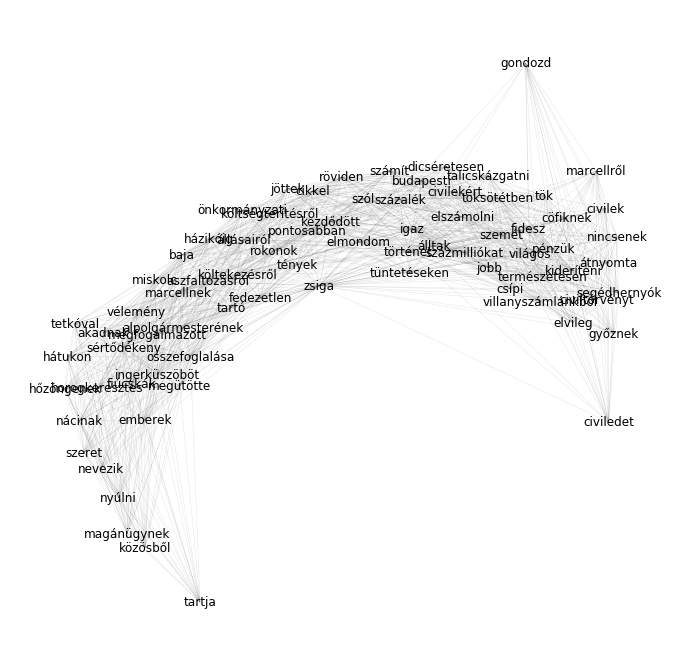

In [23]:
%pylab inline
textacy.viz.draw_semantic_network(
    textacy.keyterms.terms_to_semantic_network(
        [tok for tok in doc[:200]  if not tok.is_stop and tok.pos_ in ["NOUN", "PROPN", "ADJ", "VERB"] and tok.is_alpha],
        normalize='lower',
        edge_weighting='cooc_freq',
        window_width=20
    )
)

### Word context lookup

In [24]:
from textacy.text_utils import keyword_in_context

keyword_in_context(doc.text, "zsiga marcell", window_width=50)

y gondozd a civiledet Igaz történet a TASZ-ról és  Zsiga Marcell ről. Ha nincsenek civilek, győznek a segédhernyók.
ttük szól. Úgyhogy elmondom röviden az enyémet. A  Zsiga Marcell -sztori 2013-ban kezdődött, ezzel a cikkel. Pontos
g tartó aszfaltozásról. Ezekkel még nem volt baja  Zsiga Marcell nek, Miskolc alpolgármesterének, mindezek összefog
ívánatos, ha engem igenis lecsuknának, az aranyos  Zsiga Marcell  pedig maradna alpolgármester örökké, építhetne ha


## Word clouds

Scoring terms

In [25]:
import math
from collections import Counter 
words = [tok for tok in doc if tok.is_alpha and not tok.is_stop and tok.tag_ in ["NOUN", "VERB", "ADJ", "PROPN"]]
word_probs = {tok.text.lower(): tok.prob for tok in words}

freqs = Counter(tok.text for tok in words)
word_scores = {tok: freqs[tok] *  -word_probs[tok] for tok, prob in word_probs.items()}

In [26]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color="white", max_words=25, scale=1.5).generate_from_frequencies(freqs)
image = wordcloud.to_image()
image.save("./wordcloud.png")

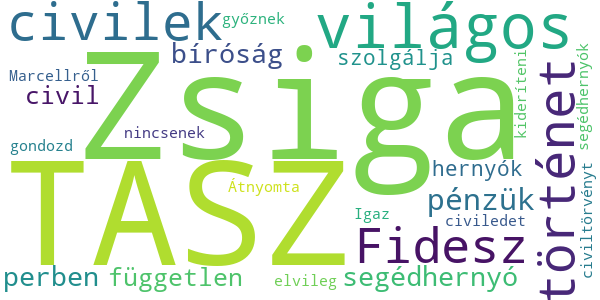

In [27]:
from IPython.display import Image 
Image(filename='./wordcloud.png')

### Popular projects built on top of spaCy

* [textacy](https://github.com/chartbeat-labs/textacy) - higher-level NLP built on spaCy
* [scattertext](https://github.com/JasonKessler/scattertext) - Beautiful visualizations of how language differs among document types
* [displaCy](https://github.com/explosion/displacy) - NLP visualiser for the modern web
* [Rasa NLU](https://github.com/RasaHQ/rasa_nlu) - a tool for intent classification and entity extraction
* [W.I.L.L](https://github.com/ironman5366/W.I.L.L) - personal assistant